In [12]:
import  numpy               as np
import  matplotlib.pyplot   as plt
from    itertools           import product
from    CAPIBARA.modules    import analysis_tes
from    scipy.optimize      import curve_fit    

# Simulation Parameters

This section defines the key parameters for the phonon propagation simulation:

## Phonon Generation
- **`n_sims`**: Number of phonons to simulate, proportional to the deposited energy in the crystal

## Crystal Geometry
- **`d1`**: Crystal dimension along x-axis (cm)
- **`d2`**: Crystal dimension along y-axis (cm)  
- **`z`**: Crystal thickness along z-axis (cm)

*Note: The simulation normalizes the crystal geometry to ±1/2 on all sides by dividing velocities and positions by these dimensions.

This formalism is due to how the TES crystals were studied.*

## Phonon Velocities
- **`v_fast`**: Velocity of fast phonon mode, propagating primarily in the z-direction (μs⁻¹)
- **`v_slow`**: Velocity of slow phonon mode, propagating in the xy-plane (μs⁻¹)

*These velocities are normalized by the crystal dimensions to work with the ±1/2 coordinate system.*

## TES Detector Properties
- **`w`**: Effective radius of each TES detector, expressed as a fraction of the crystal dimensions

*The TES physical size (1mm × 1mm = 0.1cm × 0.1cm) is converted to a normalized radius relative to the box dimensions.*

## Absorption Physics
- **`p_abs`**: Probability that a phonon is absorbed when it hits a TES detector surface

## Time Discretization
- **`dt`**: Time step for the simulation and histogram binning (μs)

In [13]:
n_sims = 2_000 #Number of phonons, proportional to energy

d1      = 2 # cm 
d2      = 2 # cm
z       = 0.04 # cm

#By dividing by the dimensions we see the box as +- 1/2 on all sides
v_fast = 1.1 / (z) #1/mus 
v_slow = 0.6 / (d1) #1/mus 

w = (0.1/2/d1) #TES dimension is 1 x 1 mm^2 = 0.1 x 0.1 cm^2 express it as a fraction of the linear box dimensions /2 for radius

p_abs = 0.0064  #probability of being absorbed 
dt = 0.5 #time step of simulation (mus)

# Crystal Geometry Setup

This section defines the geometry of the crystal detector system in the normalized coordinate space (±1/2 on all sides).

## Wall Definitions

### Wall Positions
- **`wall_top`**, **`wall_bottom`**: Top and bottom faces along the z-axis
- **`wall_left`**, **`wall_right`**: Left and right faces along the y-axis
- **`wall_up`**, **`wall_down`**: Front and back faces along the x-axis

*Each wall is positioned at the center of its respective face in the normalized coordinate system.*

### Wall Normals
- **`normal_top`** through **`normal_down`**: Unit vectors pointing inward from each wall surface

*These normals are used to calculate phonon reflections when they hit the crystal boundaries.*

## TES Detector Placement

- **`TES_1_position`**: Position of the first TES detector on the top surface
- **`TES_2_position`**: Position of the second TES detector on the top surface

*Both TES are placed on the top face (z = 1/2) at different xy-coordinates to enable position reconstruction.*

## Geometry Arrays

- **`wall_positions`**: Array containing all 6 wall center positions
- **`wall_normals`**: Array containing all 6 wall normal vectors
- **`detector_positions`**: Array of TES detector positions
- **`detector_normals`**: Array of TES normal vectors (both pointing down from top surface)
- **`detector_labels`**: List of detector names for identification

## Geometry Object

- **`crystal_geometry`**: `Geometry_TES` object that encapsulates the complete crystal geometry

*This object is passed to the simulation to define the boundary conditions and detector locations.*

In [14]:
#Active
wall_top        = np.array((0, 0, 1/2))
wall_bottom     = np.array((0, 0, -1/2))
wall_left       = np.array((0, -1/2, 0))
wall_right      = np.array((0, 1/2, 0))
wall_up         = np.array((1/2, 0, 0))
wall_down       = np.array((-1/2, 0, 0))

normal_top      = np.array((0, 0, -1))
normal_bottom   = np.array((0, 0, 1))
normal_left     = np.array((0, 1, 0))
normal_right    = np.array((0, -1, 0))
normal_up       = np.array((-1, 0, 0))
normal_down     = np.array((1, 0, 0))

TES_1_position = np.array( (1/4, 1/4, 1/2) )
TES_2_position = np.array( (1/4, -1/4, 1/2) )

wall_positions      = np.array([wall_top, wall_bottom, wall_left, wall_right, wall_up, wall_down])
wall_normals        = np.array([normal_top, normal_bottom, normal_left, normal_right, normal_up, normal_down])
detector_positions  = np.array(([TES_1_position, TES_2_position]))
detector_normals    = np.array([normal_top, normal_top])

detector_labels = ["TES_1", "TES_2"]

crystal_geometry = analysis_tes.Geometry_TES( wall_positions, detector_positions, wall_normals, detector_normals, detector_labels, w )

# Running the Simulation

This section executes the phonon propagation simulation across multiple event positions to study detector response patterns.

## Initialize Analysis Object

- **`analysis`**: Create an `Analysis_TES` instance with the defined velocities, absorption probability, and crystal geometry
- **`analysis.n_sims`**: Set the number of phonons to simulate per event position

*Note: `analysis.n_sims` can be used to change the total number of phonons without having to redefine the entire analysis object.*

## Define Event Position Grid

- **`n`**: Resolution of the spatial grid (n × n grid per surface)
- **`dx`**, **`dy`**: Arrays of x and y coordinates spanning the crystal surface, with small offsets from edges to avoid boundary effects
- **`dz`**: Two z-positions representing events on the top surface (z = +1/2) and bottom surface (z = -1/2)
- **`initial_positions`**: Cartesian product of all (x, y, z) combinations, creating a grid of starting positions

*This creates n² positions on both top and bottom surfaces (2n² total simulations).*

## Simulation Loop

- **`simulation_id`**: Counter tracking simulation progress
- **`pos_in`**: Current event position being simulated
- **`absorbed_phonons_1`**: List of (time, detector_id) pairs for each absorbed phonon
- **`hist_phonons_1`**: Histogram binning absorption times for each detector
- **`edges_ss`**: Time bin edges for the histogram
- **`charges`**: Total charge collected by each TES (sum of histogram bins)
- **`charges_arr`**: Array storing charge values for all event positions

*The loop iterates through all event positions, simulating phonon propagation and recording the charge collected by each TES.*

## Output

- **`charges_arr`**: Final array with shape (2n², 2) containing charge collected by TES 1 and TES 2 for each event position

*This data will be used for position reconstruction analysis and creating detector response maps.*

In [15]:
starting_position   = np.array((1/4, -1/4, -1/2 + 0.06))
charges_arr         = []

analysis = analysis_tes.Analysis_TES(
    crystal_geometry = crystal_geometry,
    v_fast  =   v_fast, 
    v_slow  =   v_slow, 
    p_abs   =   p_abs,
    n_sims  =   n_sims,
)

n = 7

dx = np.linspace(-1/2 + 0.05, 1/2 - 0.05, n)
dy = np.linspace(-1/2 + 0.05, 1/2 - 0.05, n)
dz = [1/2 - 0.05, -1/2 + 0.05] #top and bot events

initial_positions = np.array(list(product(dx, dy, dz)))

simulation_id = 0
for pos_in in initial_positions:
    simulation_id += 1
    if simulation_id%10 == 0:
        print(f"Progress {simulation_id/n**2/2*100:.0f}")
    _, absorbed_phonons_1 = analysis.simulation(pos_in)
    hist_phonons_1, edges_ss =  analysis.build_hist(absorbed_phonons_1) #Treat this as a baseline
    charges = np.sum(hist_phonons_1, 1)
    charges_arr.append(charges)

charges_arr = np.array(charges_arr)

c:\Users\ludov\Desktop\CAPIBARA-Ray-Phonon-Simulations\CAPIBARA\modules\analysis_tes.py:6: RuntimeWarning: divide by zero encountered in divide
  t = (np.einsum('ik,ijk->ji', n_box, -y0+p0[:, None])/(dir@n_box.T) ).T
c:\Users\ludov\Desktop\CAPIBARA-Ray-Phonon-Simulations\CAPIBARA\modules\analysis_tes.py:15: RuntimeWarning: invalid value encountered in multiply
  return (p_0 + t * dir)


Progress 10
Progress 20
Progress 31
Progress 41
Progress 51
Progress 61
Progress 71
Progress 82
Progress 92


# Visualization: Detector Response Maps

This section visualizes the simulation results to understand how detector response varies with event position.

## Reshape Data Array

- **`charges_xyz`**: Reshape the flat charges array into a 4D structure (x, y, z, detector) for easier analysis

*Dimensions: (n_x, n_y, n_z, n_detectors) where n_z=2 (top/bottom) and n_detectors=2 (TES 1/TES 2)*

## Spatial Response Heatmaps

### TES 1 Response - Top Surface
- **Top TES 1 heatmap**: Shows charge collected by TES 1 for events at different (x,y) positions on the top surface
- **Colorbar**: Indicates charge magnitude

*Events closer to TES 1 position typically show higher charge collection.*

### TES 1 Response - Bottom Surface
- **Bottom TES 1 heatmap**: Shows charge collected by TES 1 for events on the bottom surface

*Bottom events show different patterns due to longer phonon propagation paths.*

## Total Charge Distributions

- **`charges_xyz_sum`**: Sum of charge collected by both TES detectors for each event

### Top Events Histogram
- Distribution of total charge (TES 1 + TES 2) for all top surface events

*Shows the energy resolution and variation in total phonon collection efficiency.*

### Bottom Events Histogram
- Distribution of total charge for all bottom surface events

*Bottom events may show different total collection efficiency due to geometric factors and longer propagation times.*

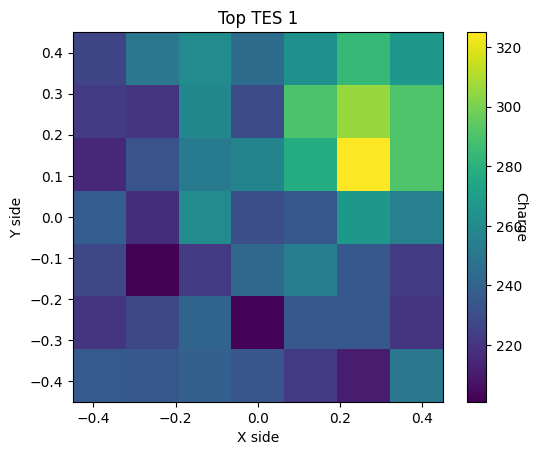

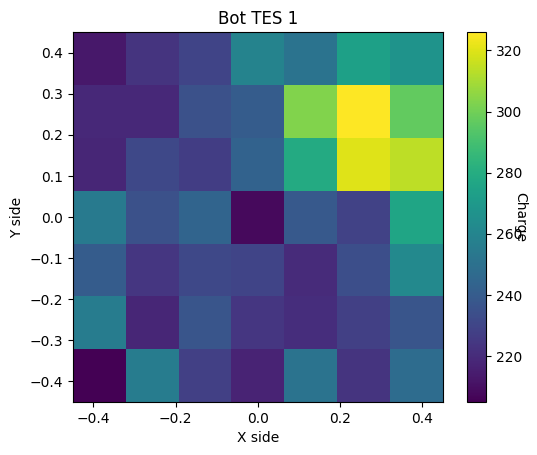

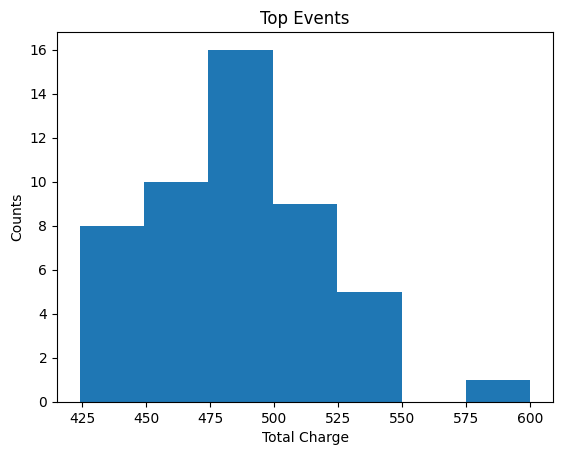

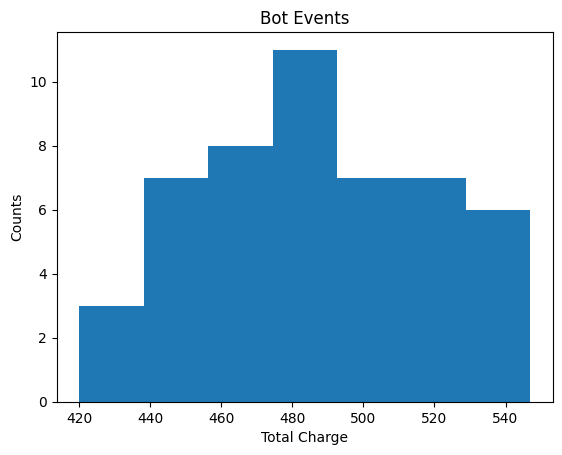

In [16]:
charges_xyz = charges_arr.reshape( (len(dx), len(dy), len(dz), 2) )

plt.imshow( charges_xyz[:,:,0,0], origin='lower', extent=[dx[0], dx[-1], dy[0], dy[-1]] )
plt.title("Top TES 1")
cbar = plt.colorbar()
cbar.set_label("Charge", rotation=270)
plt.xlabel("X side")
plt.ylabel("Y side")
plt.show()

plt.imshow( charges_xyz[:,:,1,0], origin='lower', extent=[dx[0], dx[-1], dy[0], dy[-1]] )
plt.title("Bot TES 1")
cbar = plt.colorbar()
cbar.set_label("Charge", rotation=270)
plt.xlabel("X side")
plt.ylabel("Y side")
plt.show()

#sum charge
charges_xyz_sum = np.sum(charges_xyz, 3)
plt.hist( charges_xyz_sum[:,:,0].flatten(), bins=n)
plt.xlabel("Total Charge")
plt.ylabel("Counts")
plt.title("Top Events")
plt.show()

plt.hist( charges_xyz_sum[:,:,1].flatten(), bins=n)
plt.xlabel("Total Charge")
plt.ylabel("Counts")
plt.title("Bot Events")
plt.show()

# Position Reconstruction: The "Banana Plot"

This section creates the characteristic "banana plot" used for event position reconstruction based on charge partition between detectors.

## Data Preparation

- **`charge_1_top`**, **`charge_2_top`**: Flattened arrays of charges collected by TES 1 and TES 2 for top surface events
- **`charge_1_bot`**, **`charge_2_bot`**: Flattened arrays of charges collected by TES 1 and TES 2 for bottom surface events

## Scatter Plot

- **Top events**: Plotted in one color showing the relationship between TES 1 and TES 2 charge
- **Bottom events**: Plotted in another color showing how bottom events form a distinct pattern

*Each point represents an event at a specific (x,y,z) position. The relative charges encode position information.*

## Hyperbolic Fit

- **`hyperbola`**: Fitting function of the form y = y₀ + k/(x - x₀)
- **`popt`**, **`pcov`**: Optimized parameters and covariance from curve fitting
- **`x_fit`**, **`y_fit`**: Arrays for plotting the fitted hyperbola

*The hyperbolic relationship (x - x₀)(y - y₀) = k is characteristic of phonon energy partition in detectors. Roughly becomes x + y = const for small deviations.  *

## Physical Interpretation

The "banana plot" reveals:
- Events closer to TES 1 have high TES 1 charge and low TES 2 charge
- Events closer to TES 2 have the opposite pattern

C:\Users\ludov\AppData\Local\Temp\ipykernel_19968\4148088711.py:11: RuntimeWarning: divide by zero encountered in divide
  return y0 + k / (x - x0)
C:\Users\ludov\AppData\Local\Temp\ipykernel_19968\4148088711.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(hyperbola, charge_1_top, charge_2_top, p0=[min(charge_1_top), min(charge_2_top), 1e3])


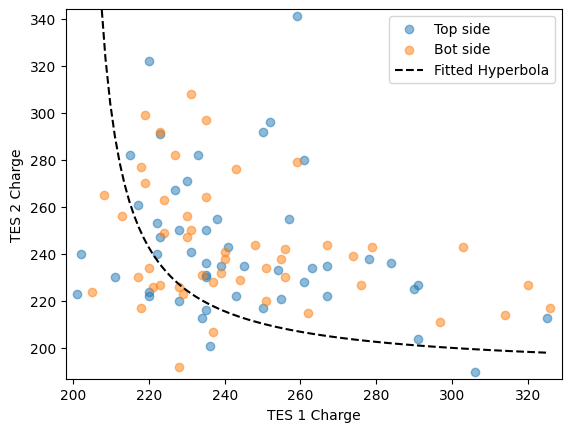

In [17]:
#scatter plot of charges

charge_1_top = charges_xyz[:,:,0,0].flatten()
charge_2_top = charges_xyz[:,:,0,1].flatten()
charge_1_bot = charges_xyz[:,:,1,0].flatten()
charge_2_bot = charges_xyz[:,:,1,1].flatten()

plt.scatter( charge_1_top, charge_2_top, alpha=0.5, label="Top side")
plt.scatter( charge_1_bot, charge_2_bot, alpha=0.5, label="Bot side")
def hyperbola(x, x0, y0, k):
    return y0 + k / (x - x0)
# fit the hyperbola to the data
popt, pcov = curve_fit(hyperbola, charge_1_top, charge_2_top, p0=[min(charge_1_top), min(charge_2_top), 1e3])
x_fit = np.linspace(min(charges_xyz[:,:,0,0].flatten()), max(charges_xyz[:,:,0,0].flatten()), 100)
y_fit = hyperbola(x_fit, *popt)
plt.plot(x_fit, y_fit, 'k--', label="Fitted Hyperbola")
plt.xlim(min(min(charge_1_bot), min(charge_1_top))-3, max(max(charge_1_bot), max(charge_1_top))+3)
plt.ylim(min(min(charge_2_bot), min(charge_2_top))-3, max(max(charge_2_bot), max(charge_2_top))+3)
plt.xlabel("TES 1 Charge")
plt.ylabel("TES 2 Charge")
plt.legend()
plt.savefig(f"banana{n}_t_b.pdf")
plt.show()

# Distance-Based Position Reconstruction Analysis

This section analyzes the relationship between physical distance to detectors and the charge partition, providing insight into position reconstruction capabilities.

## Coordinate Conversion

- **`normalized_to_physical(pos)`**: Helper function to convert normalized coordinates (±1/2) back to physical units (cm)
  - Multiplies x-coordinate by `d1` (2 cm)
  - Multiplies y-coordinate by `d2` (2 cm)
  - Multiplies z-coordinate by `z` (0.04 cm)

*This conversion is necessary because the simulation operates in normalized coordinates for computational efficiency.*

## Data Processing

### Distance Calculations
- **`TES_1_position_cm`**, **`TES_2_position_cm`**: TES positions in physical coordinates (cm)
- **`distances_to_tes1`**, **`distances_to_tes2`**: Euclidean distances from each event position to each TES detector
- **`charge_ratios`**: Ratio of charge collected by TES 1 to TES 2 (TES 1 / TES 2)

*The charge ratio provides a single parameter encoding the relative proximity to each detector.*

## Visualization: Three-Panel Analysis

### Panel 1: Distance to TES 1 vs Charge Ratio
- **Scatter plot** showing how charge ratio varies with distance to TES 1
- **Blue points**: Each represents one simulated event position
- **Expected trend**: Charge ratio decreases as distance to TES 1 increases

*Events far from TES 1 have lower TES 1 charge, resulting in smaller ratios.*

### Panel 2: Distance to TES 2 vs Charge Ratio
- **Scatter plot** showing charge ratio variation with distance to TES 2
- **Red points**: Each event position plotted
- **Expected trend**: Charge ratio increases as distance to TES 2 increases

*Events far from TES 2 have lower TES 2 charge, resulting in larger ratios.*

### Panel 3: Distance Difference vs Charge Ratio
- **Combined metric**: (Distance to TES 1) - (Distance to TES 2)
- **Reference lines**:
  - Horizontal line at y=1: Equal charge partition
  - Vertical line at x=0: Equidistant from both detectors
- **Correlation**: Should show clear monotonic relationship

*This plot demonstrates that charge ratio can be used to infer relative position between detectors.*

## Physical Interpretation

### Position Sensitivity
- **Positive distance difference**: Event closer to TES 2 → Higher charge ratio (more charge in TES 1 relative to nearby TES 2)
- **Negative distance difference**: Event closer to TES 1 → Lower charge ratio (more charge in TES 2 relative to nearby TES 1)
- **Zero distance difference**: Event equidistant → Charge ratio ≈ 1 However in practice there are multiple points that are relatively equidistant but not exactly the same distance so there is some spread around 1.

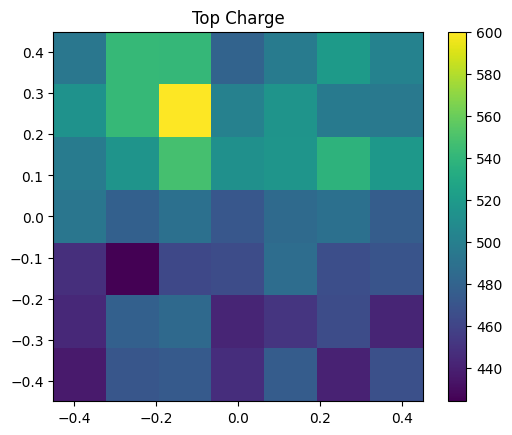

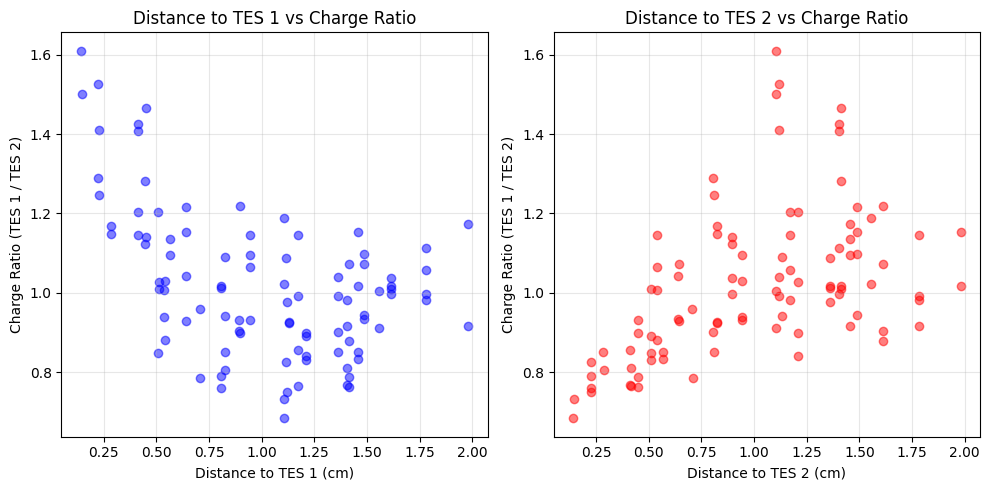

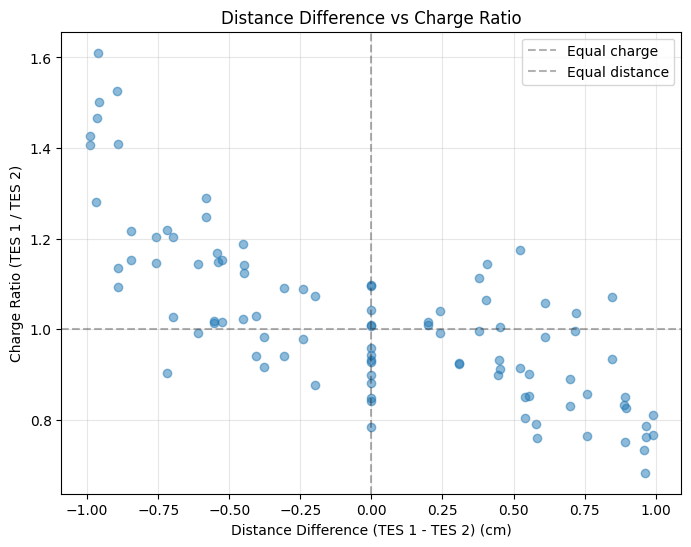

In [19]:
plt.imshow( charges_xyz[:,:,0].sum(2), origin='lower', extent=[dx[0], dx[-1], dy[0], dy[-1]] )
plt.title("Top Charge")
plt.colorbar()
plt.show()

# Distance vs Charge Ratio Analysis (with proper physical distances in cm)

# Convert normalized positions back to physical units (cm)
# Remember: normalized coordinates are in ±1/2, multiply by actual dimensions
def normalized_to_physical(pos):
    """Convert normalized coordinates to physical cm"""
    return np.array([pos[0] * d1, pos[1] * d2, pos[2] * z])

TES_1_position_cm = normalized_to_physical(TES_1_position)
TES_2_position_cm = normalized_to_physical(TES_2_position)

distances_to_tes1 = []
distances_to_tes2 = []
charge_ratios = []

for i, pos_normalized in enumerate(initial_positions):
    # Convert to physical coordinates
    pos_cm = normalized_to_physical(pos_normalized)
    
    # Calculate Euclidean distance in cm
    dist_1 = np.linalg.norm(pos_cm - TES_1_position_cm)
    dist_2 = np.linalg.norm(pos_cm - TES_2_position_cm)
    
    distances_to_tes1.append(dist_1)
    distances_to_tes2.append(dist_2)
    
    # Calculate charge ratio (TES1 / TES2)
    if charges_arr[i, 1] > 0:  # Avoid division by zero
        ratio = charges_arr[i, 0] / charges_arr[i, 1]
        charge_ratios.append(ratio)
    else:
        charge_ratios.append(np.nan)

distances_to_tes1 = np.array(distances_to_tes1)
distances_to_tes2 = np.array(distances_to_tes2)
charge_ratios = np.array(charge_ratios)

# Plot distance to TES1 vs charge ratio
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(distances_to_tes1, charge_ratios, alpha=0.5, c='blue')
plt.xlabel("Distance to TES 1 (cm)")
plt.ylabel("Charge Ratio (TES 1 / TES 2)")
plt.title("Distance to TES 1 vs Charge Ratio")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(distances_to_tes2, charge_ratios, alpha=0.5, c='red')
plt.xlabel("Distance to TES 2 (cm)")
plt.ylabel("Charge Ratio (TES 1 / TES 2)")
plt.title("Distance to TES 2 vs Charge Ratio")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Alternative: Distance difference vs charge ratio
distance_diff = distances_to_tes1 - distances_to_tes2

plt.figure(figsize=(8, 6))
plt.scatter(distance_diff, charge_ratios, alpha=0.5)
plt.xlabel("Distance Difference (TES 1 - TES 2) (cm)")
plt.ylabel("Charge Ratio (TES 1 / TES 2)")
plt.title("Distance Difference vs Charge Ratio")
plt.axhline(y=1, color='k', linestyle='--', alpha=0.3, label='Equal charge')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3, label='Equal distance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Time Evolution Analysis for Single Event

This section examines the temporal dynamics of phonon collection for a single event position, revealing how phonons arrive at the detectors over time.

## Example Position Selection

- **`example_position`**: Event position at (1/4 + 0.1, 1/4 + 0.1, 1/2 - 0.05) in normalized coordinates
  - Located on the **top surface** (z ≈ 1/2)
  - **Close to TES 1** positioned at (1/4, 1/4, 1/2)
  - **Far from TES 2** positioned at (1/4, -1/4, 1/2)

*This asymmetric position demonstrates how proximity to a detector affects both charge collection and timing.*

## Simulation and Data Processing

- **`absorbed_phonons_example`**: Raw list of (time, detector_id) pairs from simulation
- **`hist_phonons_example`**: Histogram of phonon arrival times for each TES, binned at dt intervals
- **`response_example`**: Convolved detector response simulating actual TES signal using exponential rise/fall function
- **`t_response`**: Time array for the response signal

## Four-Panel Visualization

### Panel 1: Raw Phonon Arrival Histogram
- **Step plot** showing discrete phonon arrivals at each time bin
- **Blue (TES 1)** vs **Red (TES 2)** distinguishes detector signals
- Reveals the **temporal structure** of phonon propagation

*Events close to a detector show earlier and more intense phonon arrival.*

### Panel 2: Detector Response
- **Smooth curves** from convolving arrival histogram with detector impulse response
- Models the **actual electrical signal** from each TES
- Response has characteristic rise time (τ_rise = 10 μs) and fall time (τ_fall = 200 μs)

*This is the signal that would be measured in a real experiment.*

### Panel 3: Cumulative Charge Collection
- **Running sum** of phonon arrivals over time
- Shows how total collected charge builds up
- **Final plateau** indicates total charge collected by each TES

*Demonstrates the time scale for complete phonon collection (~100-200 μs).*

### Panel 4: Position Information Summary
- **Physical distances** to each TES in cm (converted from normalized coordinates)
- **Total charge** collected by each detector
- **Charge ratio** (TES 1 / TES 2) encoding position information

*For this example: TES 1 should collect significantly more charge than TES 2 due to proximity.*

## Physical Insights

This analysis demonstrates:
1. **Proximity effect**: Closer detector sees more phonons arriving earlier
2. **Time structure**: Fast phonons arrive first (z-direction), followed by slower diffusing phonons
3. **Charge partition**: Total charge ratio between detectors depends on event position
4. **Signal shape**: Detector response shows realistic rise/fall behavior for data analysis

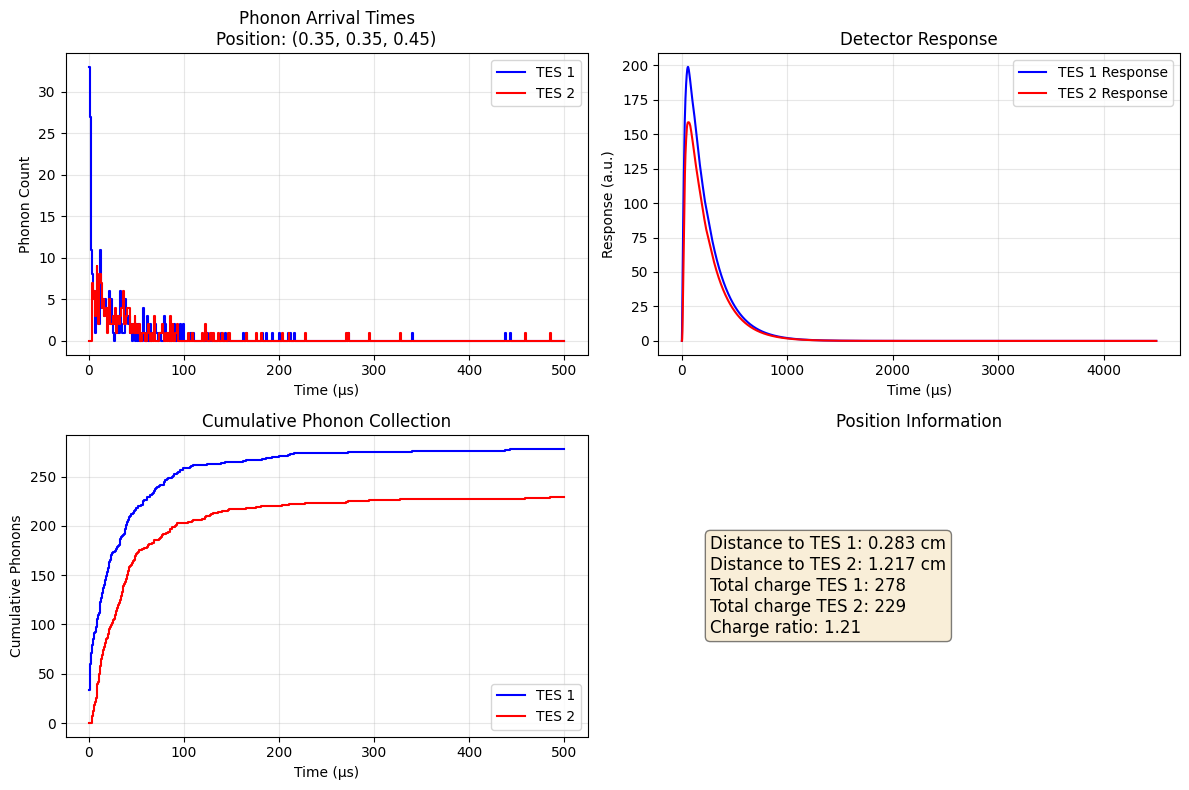

In [22]:
# Time Evolution for Example Position

# Choose a position close to TES 1 (at 1/4, 1/4) and far from TES 2 (at 1/4, -1/4)
example_position = np.array((1/4 + 0.1, 1/4 + 0.1, 1/2 - 0.05))  # Close to TES 1, top surface

# Run simulation for this position
_, absorbed_phonons_example = analysis.simulation(example_position)

# Build histogram and response
hist_phonons_example, edges_example = analysis.build_hist(absorbed_phonons_example)
response_example, t_response = analysis.build_response(hist_phonons_example)

# Plot the time evolution
plt.figure(figsize=(12, 8))

# Plot 1: Raw phonon arrival histogram
plt.subplot(2, 2, 1)
plt.step(edges_example, hist_phonons_example[0], where='mid', label='TES 1', color='blue')
plt.step(edges_example, hist_phonons_example[1], where='mid', label='TES 2', color='red')
plt.xlabel("Time (μs)")
plt.ylabel("Phonon Count")
plt.title(f"Phonon Arrival Times\nPosition: ({example_position[0]:.2f}, {example_position[1]:.2f}, {example_position[2]:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Detector response (convolved signal)
plt.subplot(2, 2, 2)
plt.plot(t_response, response_example[0], label='TES 1 Response', color='blue')
plt.plot(t_response, response_example[1], label='TES 2 Response', color='red')
plt.xlabel("Time (μs)")
plt.ylabel("Response (a.u.)")
plt.title("Detector Response")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Cumulative charge collection
plt.subplot(2, 2, 3)
cumulative_tes1 = np.cumsum(hist_phonons_example[0])
cumulative_tes2 = np.cumsum(hist_phonons_example[1])
plt.step(edges_example, cumulative_tes1, where='mid', label='TES 1', color='blue')
plt.step(edges_example, cumulative_tes2, where='mid', label='TES 2', color='red')
plt.xlabel("Time (μs)")
plt.ylabel("Cumulative Phonons")
plt.title("Cumulative Phonon Collection")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Distance information
plt.subplot(2, 2, 4)
pos_cm = normalized_to_physical(example_position)
tes1_cm = normalized_to_physical(TES_1_position)
tes2_cm = normalized_to_physical(TES_2_position)
dist_tes1 = np.linalg.norm(pos_cm - tes1_cm)
dist_tes2 = np.linalg.norm(pos_cm - tes2_cm)
charge_ratio = hist_phonons_example[0].sum() / hist_phonons_example[1].sum() if hist_phonons_example[1].sum() > 0 else np.inf

info_text = f"Distance to TES 1: {dist_tes1:.3f} cm\n"
info_text += f"Distance to TES 2: {dist_tes2:.3f} cm\n"
info_text += f"Total charge TES 1: {hist_phonons_example[0].sum():.0f}\n"
info_text += f"Total charge TES 2: {hist_phonons_example[1].sum():.0f}\n"
info_text += f"Charge ratio: {charge_ratio:.2f}"

plt.text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.axis('off')
plt.title("Position Information")

plt.tight_layout()
plt.show()